![ecg_filter_diagram](./img/ecg_filter_diagram.png)

In [1]:
import itertools as it
import time  # for sleep
from importlib import reload
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import padasip as pa  # adaptive filter package
import pandas as pd
import scipy as sp
from IPython.display import clear_output
from tqdm import tqdm # progress bar

# from lms import lms_filter, LmsResult
from filters.LMS import Result as LmsResult
from filters.LMS import lms
from filters.utils import SNR, signaltonoise

np.random.seed(42069) # always use the same random seed to make results comparable

In [2]:
# read ecg.dat into a numpy array
ecg = np.loadtxt('./data/ecg.dat')
n_samples = ecg.size

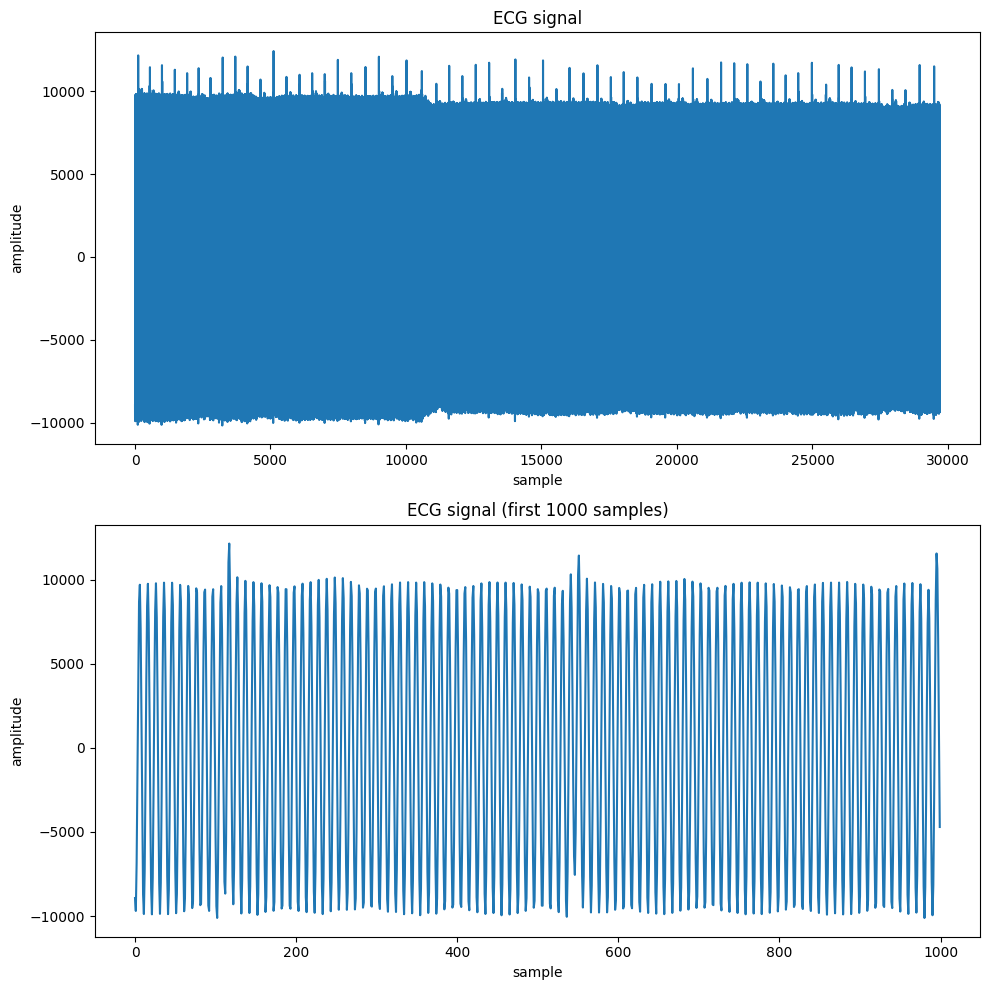

In [3]:
# plot ecg signal twice, once with the original signal and once with the first 1000 samples
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(ecg)
ax[0].set_title('ECG signal')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('amplitude')
ax[1].plot(ecg[:1000])
ax[1].set_title('ECG signal (first 1000 samples)')
ax[1].set_xlabel('sample')
ax[1].set_ylabel('amplitude')
plt.tight_layout()
plt.show()

Power line frequency: 49.56 Hz


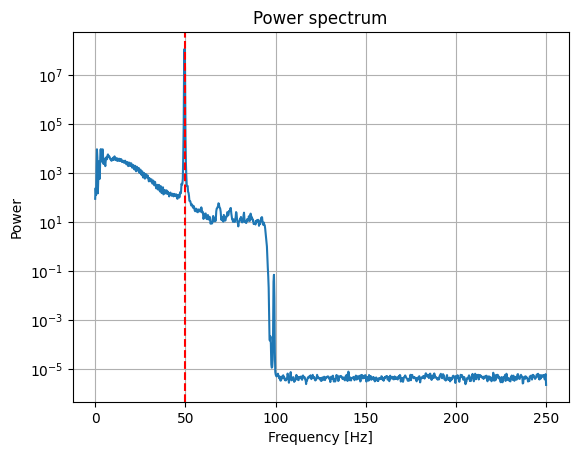

In [4]:
# find power line frequency (50 Hz)
Fs = 500 # sampling frequency
f, pxx = sp.signal.welch(ecg, Fs, nperseg=2048) # nperseg is the number of samples per segment i.e. the length of the window

max_pxx_idx: int = np.argmax(pxx)
powerline_freq: float = f[max_pxx_idx]
print(f'Power line frequency: {powerline_freq:.2f} Hz')

# plot power spectrum
plt.figure()
plt.plot(f, pxx)
plt.title('Power spectrum')
plt.xlabel('Frequency [Hz]')
plt.yscale('log') # more meaningful scale
plt.grid()
plt.ylabel('Power')
plt.axvline(x=powerline_freq, color='red', linestyle='--') # mark power line frequency
plt.savefig('./img/ecg_power_spectrum.png')
plt.show()

## 2  How many filter coeffcients are needed in the adaptive filter?

We have **1** frequency (50 Hz) that we want to affect, so we need **2** taps. <br>
With 1 tap we can only affect the gain of the signal, as we only have a scalar in H(z) <br>
With 2 taps we can affect both the gain and phase of the signal, as H(z) = a + bz^-1

In [51]:
suggested_n_taps = 2

## 3  Implement an LMS filter which removes the ECG signal from a generated sinusoid at the power line frequency.

In [52]:
# input signal is cos(2*pi*50*t)
synthetic_cosine_at_powerline_freq = np.cos(2 * np.pi * powerline_freq / Fs * np.arange(n_samples))

## 4  Select an appropriate value for the step-size μ.

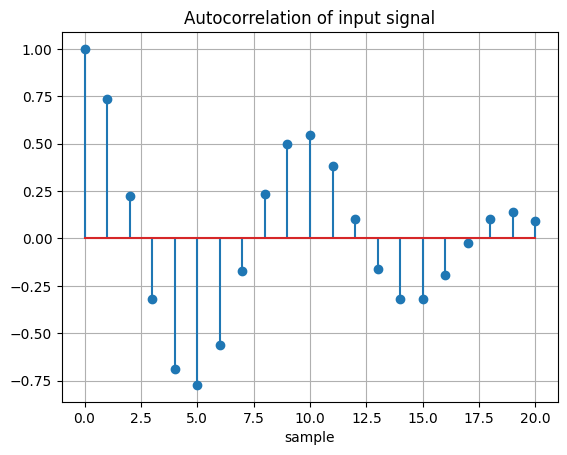

In [53]:
lags = 21

def autocorr(x: np.ndarray, order: int, lags: int = 21) -> np.ndarray:
    rx = sp.signal.correlate(x[:lags], x[:lags], mode='full')
    rx = rx[(rx.size//2):] # take only the positive lags
    rx /= rx[0] # normalize

    # toepliz matrix
    Rxx = sp.linalg.toeplitz(rx[(rx.size // 2):]) # take only the positive lags
    # see equ. 6.73 for why we slice [:ntaps, :ntaps]
    Rxx = sp.linalg.toeplitz(rx[(rx.size // 2):])[:order, :order] # take only the positive lags
    return rx, Rxx

rx, Rxx = autocorr(synthetic_cosine_at_powerline_freq, suggested_n_taps)

# plot autocorrelation of input signal
plt.figure()
plt.stem(rx)
plt.title('Autocorrelation of input signal')
plt.grid()
plt.xlabel('sample')
plt.show()

![lms-stability-condition](./screenshots/stability-condition-for-lms.png)

In [49]:
trR = np.trace(Rxx)

upper_limit_for_learning_rate_with_lms = 1 / (3 * trR)
upper_limit_for_learning_rate_with_lms

print(f'0 < mu < {upper_limit_for_learning_rate_with_lms:.2f}')

0 < mu < 0.31


In [59]:
def plot_filtered_ecg_signal(adaptive_filter_result, xlim_intervals = [(0, n_samples), (24500, 27000), (0, 2500)], plot_loss_curve: bool = True) -> None:
    n_plots = len(xlim_intervals)
    n_plots += 1 if plot_loss_curve else 0

    _, ax = plt.subplots(n_plots, 1, figsize=(10, 12))

    err = adaptive_filter_result.err
    mse = adaptive_filter_result.mse

    for i, (xlim_min, xlim_max) in enumerate(xlim_intervals):
        ax[i].plot(ecg)
        ax[i].plot(err)
        ax[i].set_title(f'samples {xlim_min} to {xlim_max}')
        ax[i].set_xlabel('sample')
        ax[i].set_ylabel('amplitude')
        ax[i].set_ylim(-2000, 5000)
        ax[i].set_xlim(xlim_min, xlim_max)
        ax[i].legend(['Noisy ECG signal', 'Error signal (filtered ECG)'])
        
    # plot loss curve
    if plot_loss_curve:
        ax[n_plots - 1].plot(mse)
        ax[n_plots - 1].set_title('Loss curve')
        ax[n_plots - 1].set_xlabel('iteration')
        ax[n_plots - 1].semilogy()
        ax[n_plots - 1].set_ylabel('MSE (log scale)')
        ax[n_plots - 1].grid()

    plt.tight_layout()
    plt.show()

In [54]:
mu = 0.3 # step size between 0 and 1 / (3 * trR)

lms_result: LmsResult = lms(synthetic_cosine_at_powerline_freq, ecg, mu, suggested_n_taps)
y = lms_result.y
err = lms_result.err


/home/kristoffer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kristoffer/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


##  5 Examine the error-signal e(k) by plotting it and comparing it with the original noisy ECG-signal.

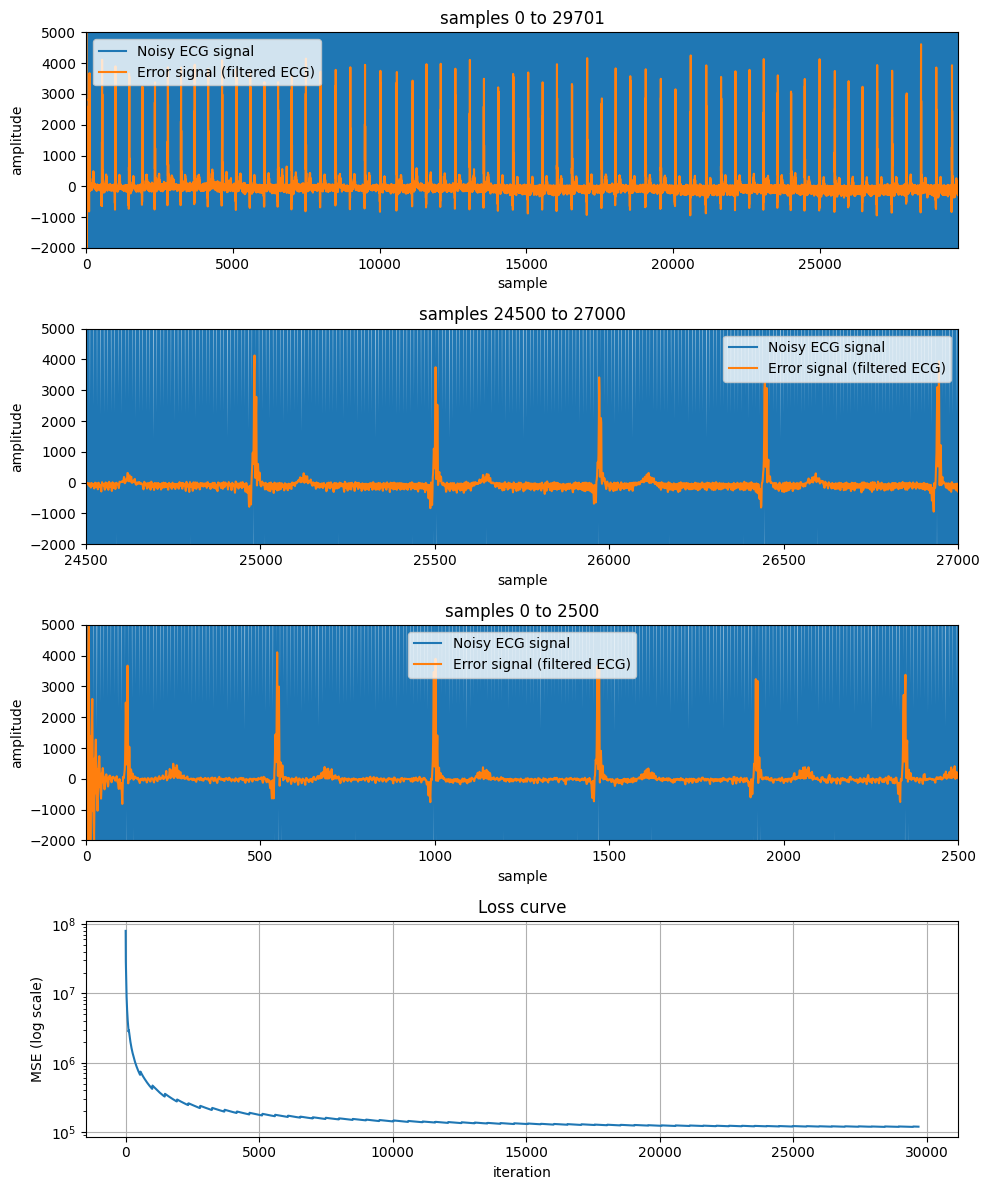

In [60]:
plot_filtered_ecg_signal(lms_result)

/tmp/ipykernel_125642/1918210332.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1].scatter(w[:, 0], w[:, 1], cmap=viridis,s=1)


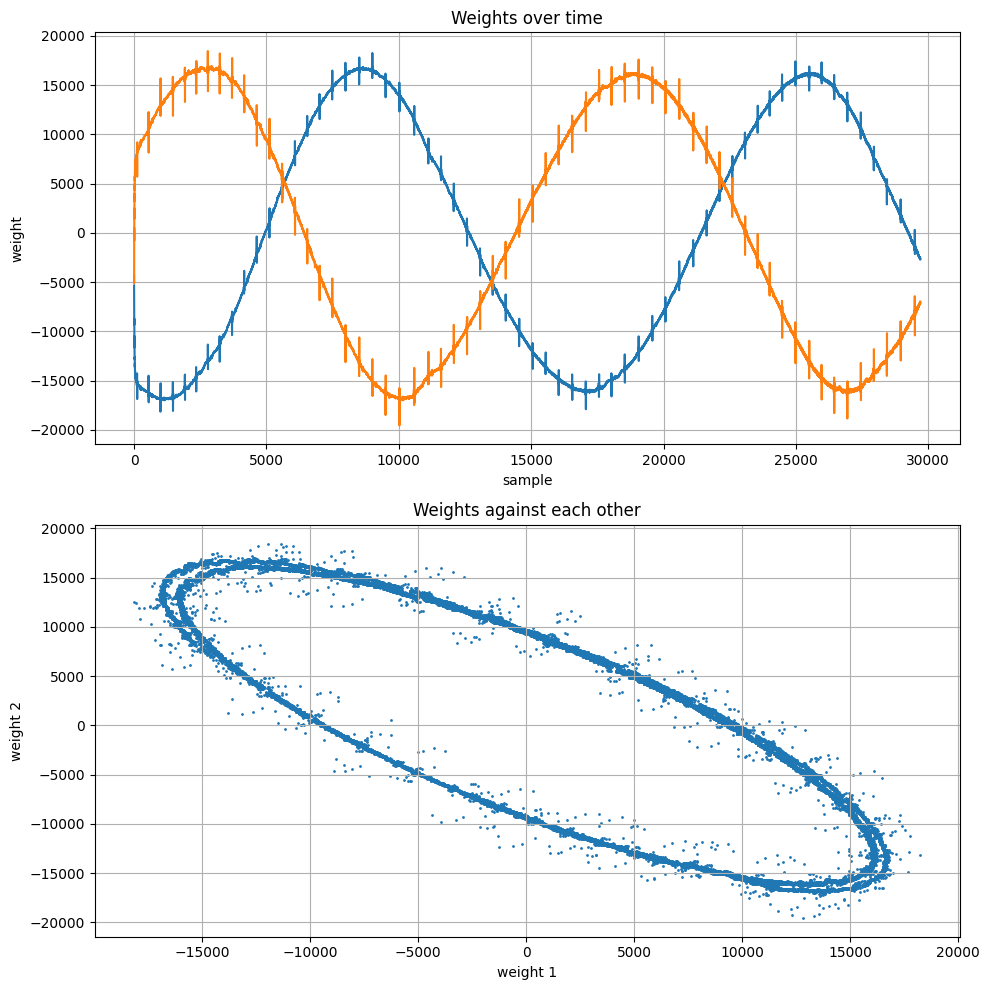

In [11]:
# plot weights over time and against each other
w = lms_result.w

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(w)
ax[0].set_title('Weights over time')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('weight')
ax[0].grid()

viridis = plt.get_cmap('viridis')
ax[1].scatter(w[:, 0], w[:, 1], cmap=viridis,s=1)
ax[1].set_title('Weights against each other')
ax[1].set_xlabel('weight 1')
ax[1].set_ylabel('weight 2')
ax[1].grid()

plt.tight_layout()
plt.show()

## 6  Adjust your parameters μ and the number of filter coefficients and see how good results you can acheive. If possible, estimate the improvement in signal-to-noise ratio.

In [63]:
snrs = []

lags = 21

# test 2,3, ..., 8 taps
for taps in tqdm(range(2, 8 + 1), ncols=100):

    # rx = sp.signal.correlate(synthetic_cosine_at_powerline_freq[:lags], synthetic_cosine_at_powerline_freq[:lags], mode='full')
    # rx = rx[(rx.size//2):] # take only the positive lags
    # rx /= rx[0] # normalize

    # Rxx = sp.linalg.toeplitz(rx[(rx.size // 2):])[:taps, :taps] # take only the positive lags


    _, Rxx = autocorr(synthetic_cosine_at_powerline_freq, taps)

    mu = 1 / (3 * np.trace(Rxx))
    # print(f'0 < mu < {mu:.2f}')
  
    result: LmsResult = lms(synthetic_cosine_at_powerline_freq, ecg, mu, taps)
    err = result.err
    snr = SNR(err, ecg[:-(taps - 1)] - err)
    snrs.append((taps, mu, snr))


  0%|                                                                         | 0/7 [00:00<?, ?it/s]/home/kristoffer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kristoffer/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


In [62]:
snrs_sorted = sorted(snrs, key=lambda x: x[2], reverse=True)
best = snrs_sorted[0]
worst = snrs_sorted[-1]

df = pd.DataFrame(snrs_sorted, columns=['taps', 'mu', 'snr'])
print(df.head(10))

   taps        mu        snr
0     5  0.122335 -24.577611
1     6  0.101945 -24.650588
2     8  0.076459 -24.673266
3     7  0.087382 -24.708911
4     4  0.152918 -24.720678
5     3  0.203891 -25.207885
6     2  0.305836 -25.778836


Run with 5 taps and mu = 0.12


/home/kristoffer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kristoffer/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


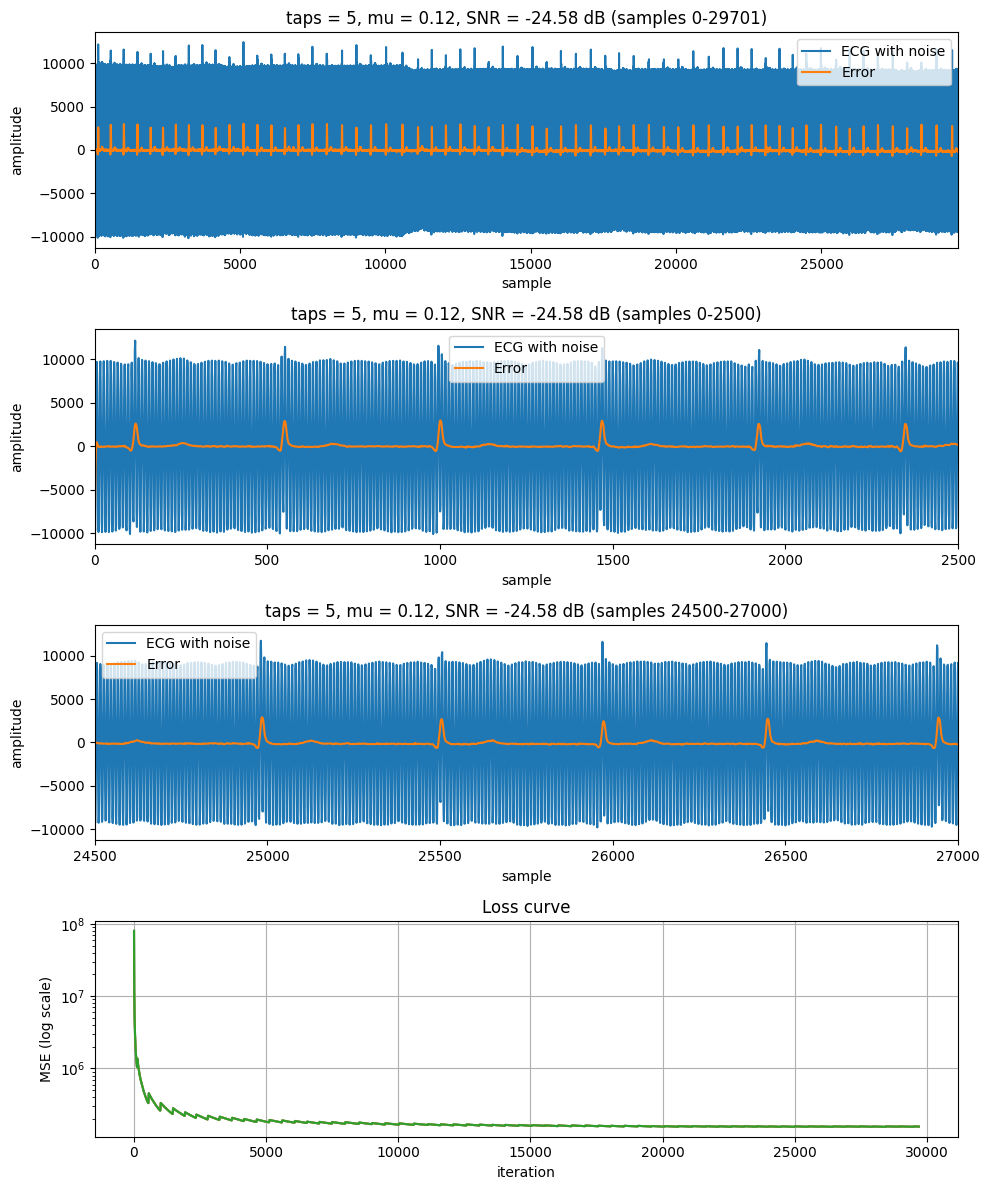

Run with 2 taps and mu = 0.31


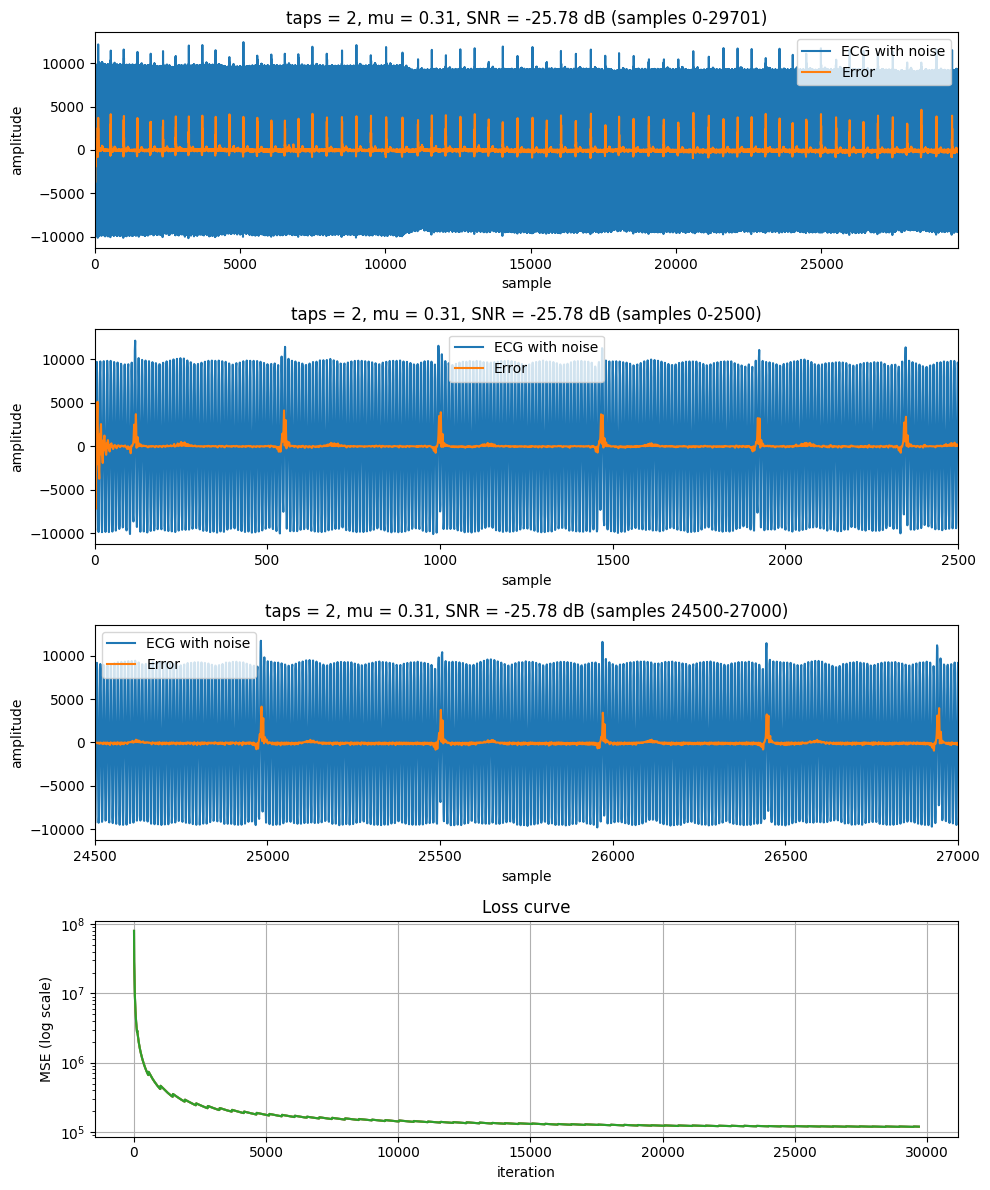

In [14]:
for run in {best, worst}:
    taps, mu, snr = run
    print(f'Run with {taps} taps and mu = {mu:.2f}')

    result: LmsResult = lms(synthetic_cosine_at_powerline_freq, ecg, mu, taps)

    _, ax = plt.subplots(4, 1, figsize=(10, 12))

    for i, (xlim_min, xlim_max) in enumerate([(0, n_samples), (0, 2500), (24500, 27000)]):
        ax[i].plot(ecg)
        ax[i].plot(result.err)
        ax[i].set_title(f'taps = {taps}, mu = {mu:.2f}, SNR = {snr:.2f} dB (samples {xlim_min}-{xlim_max})')
        ax[i].set_xlabel('sample')
        ax[i].set_ylabel('amplitude')
        ax[i].set_xlim(xlim_min, xlim_max)
        ax[i].legend(['ECG with noise', 'Error'])

        # plot loss curve
        ax[3].plot(result.mse)
        ax[3].set_title('Loss curve')
        ax[3].set_xlabel('iteration')
        ax[3].semilogy()
        ax[3].set_ylabel('MSE (log scale)')
        ax[3].grid()

    plt.tight_layout()
    plt.show()

---
## Adaptive Line Enhancer

In [37]:
ale_results = []

lags = 21

for delay, taps in tqdm(it.product(np.arange(1,5), np.arange(2, 5)), ncols=100, total=12):
    ecg_delayed = np.concatenate((np.zeros(delay), ecg[:-delay]))

    rx = sp.signal.correlate(ecg_delayed[:lags], ecg_delayed[:lags], mode='full')
    rx = rx[(rx.size//2):] # take only the positive lags
    rx /= rx[0] # normalize

    Rxx = sp.linalg.toeplitz(rx[(rx.size // 2):])[:taps, :taps] # take only the positive lags

    mu = 1 / (3 * np.trace(Rxx)) * 1e-5 # 1e-7 is a magic number that works well, as the step_size needs to be small enough to not diverge

    result: LmsResult = lms(ecg_delayed, ecg, mu, taps)
    err = result.err
    snr = 10 * np.log10(signaltonoise(err))
    # snr = SNR(err, ecg[:-(taps - 1)] - err)
    ale_results.append((delay, taps, mu, snr))
    # print(f'Run with {taps} taps, delay = {delay}, mu = {mu:.9f}, snr = {snr:.4f} finished')
    

ale_results_sorted = sorted(ale_results, key=lambda x: x[3], reverse=True)

  0%|                                                                        | 0/12 [00:00<?, ?it/s]/home/kristoffer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kristoffer/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kristoffer/Documents/university/7-semester/advanced-signal-processing/assignments/assignment-2/filters/LMS.py:57: RuntimeWarning: overflow encountered in square
  mse[i] = np.mean(err[:i] ** 2)
  8%|█████▎                                                          | 1/12 [00:01<00:16,  1.52s/it]/home/kristoffer/Documents/university/7-semester/advanced-signal-processing/assignments/assignment-2/filters/LMS.py:60: RuntimeWarning: invalid value encountered in add
  w += mu * 2 * err[i] * x_window
 75%|█████████████████████████████████████████

In [38]:
df = pd.DataFrame(ale_results_sorted, columns=['delays', 'taps', 'mu', 'snr'])
print(np.all(np.isnan(df['snr'])))

True


Run with 2 taps and delay = 1


/home/kristoffer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kristoffer/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kristoffer/Documents/university/7-semester/advanced-signal-processing/assignments/assignment-2/filters/LMS.py:57: RuntimeWarning: overflow encountered in square
  mse[i] = np.mean(err[:i] ** 2)
/home/kristoffer/.local/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


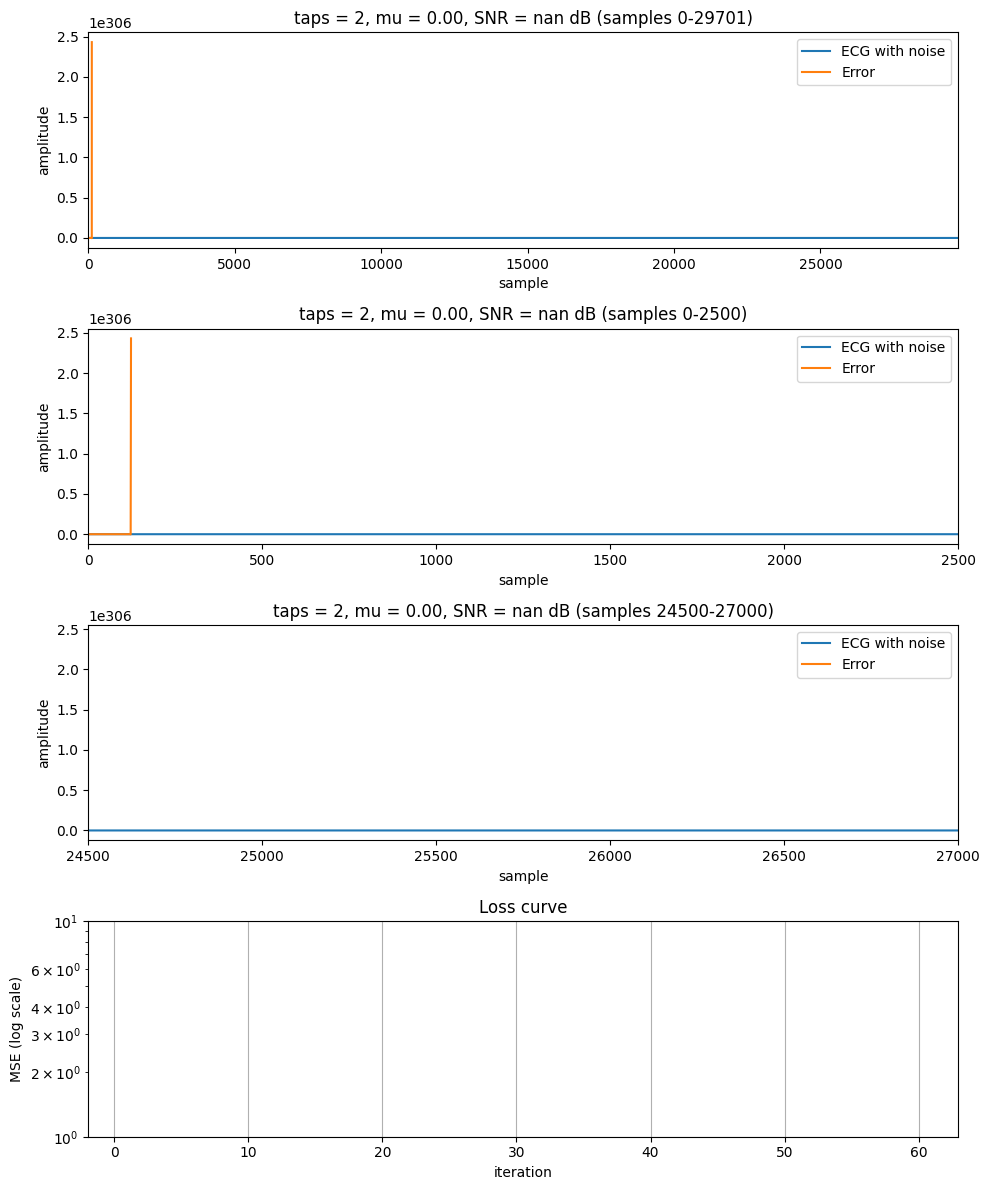

Run with 4 taps and delay = 4


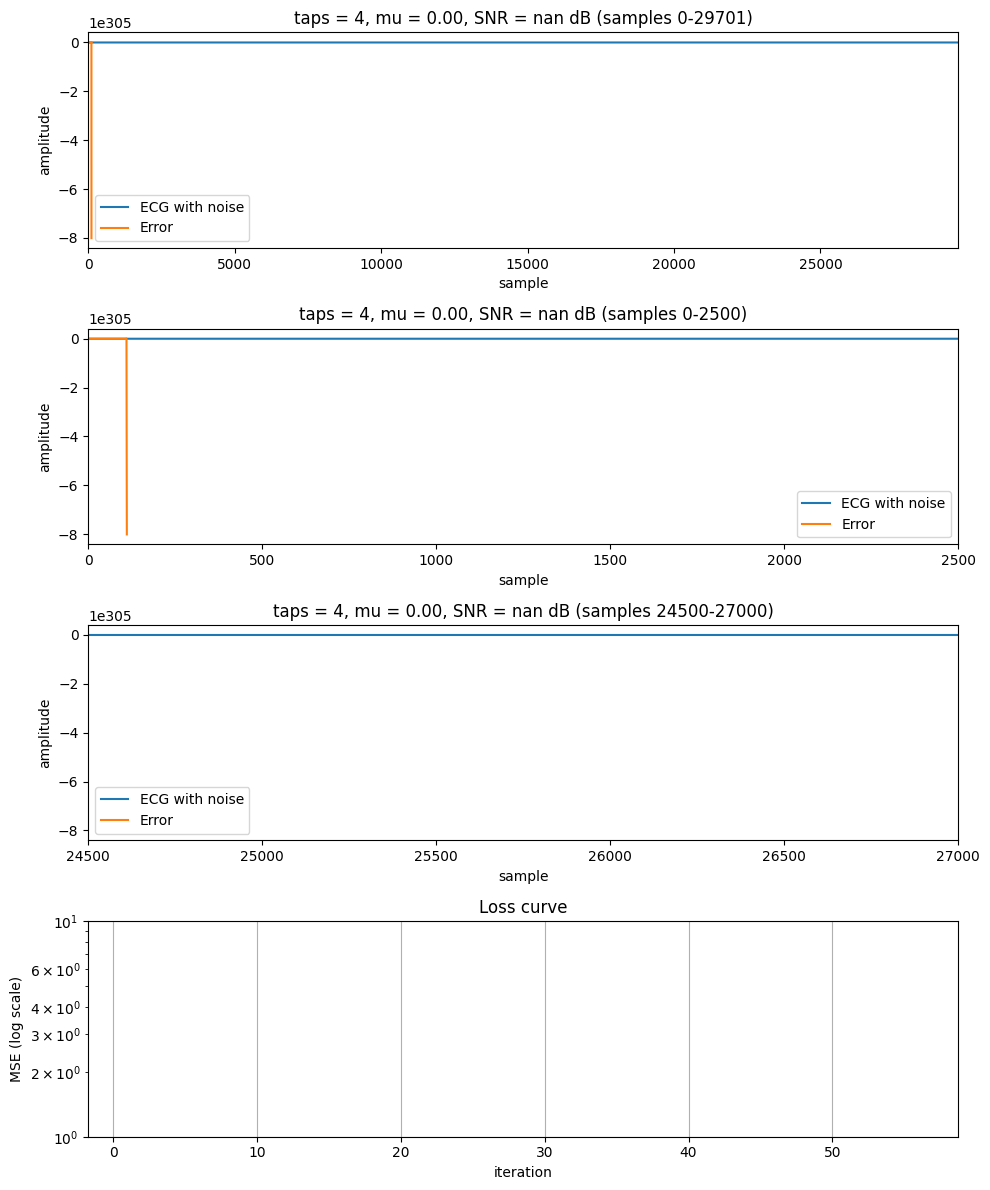

In [39]:
ale_best = ale_results_sorted[0]
ale_worst = ale_results_sorted[-1]

for run in {ale_best, ale_worst}:
    delay, taps, mu, snr = run
    print(f'Run with {taps} taps and delay = {delay}')

    ecg_delayed = np.concatenate((np.zeros(delay), ecg[:-delay]))

    result: LmsResult = lms(ecg_delayed, ecg, mu, taps)

    _, ax = plt.subplots(4, 1, figsize=(10, 12))

    for i, (xlim_min, xlim_max) in enumerate([(0, n_samples), (0, 2500), (24500, 27000)]):
        ax[i].plot(ecg)
        ax[i].plot(result.err)
        ax[i].set_title(f'taps = {taps}, mu = {mu:.2f}, SNR = {snr:.2f} dB (samples {xlim_min}-{xlim_max})')
        ax[i].set_xlabel('sample')
        ax[i].set_ylabel('amplitude')
        ax[i].set_xlim(xlim_min, xlim_max)
        ax[i].legend(['ECG with noise', 'Error'])

        # plot loss curve
        ax[3].plot(result.mse)
        ax[3].set_title('Loss curve')
        ax[3].set_xlabel('iteration')
        ax[3].semilogy()
        ax[3].set_ylabel('MSE (log scale)')
        ax[3].grid()

    plt.tight_layout()
    plt.show()

---

## Lets try with a NMLS filter instead

In [31]:
# from importlib import reload
# import nlms
from filters.NMLS import nlms, Result as NlmsResult
# reload(nlms) # reload the module to get the latest changes without restarting the kernel

psi = 0.1
mu = 0.3 # step size between 0 and 1 / (3 * trR)
n_taps = 2

nmls_result: NlmsResult = nlms(synthetic_cosine_at_powerline_freq, ecg, mu=mu, n_taps=n_taps, psi=psi)

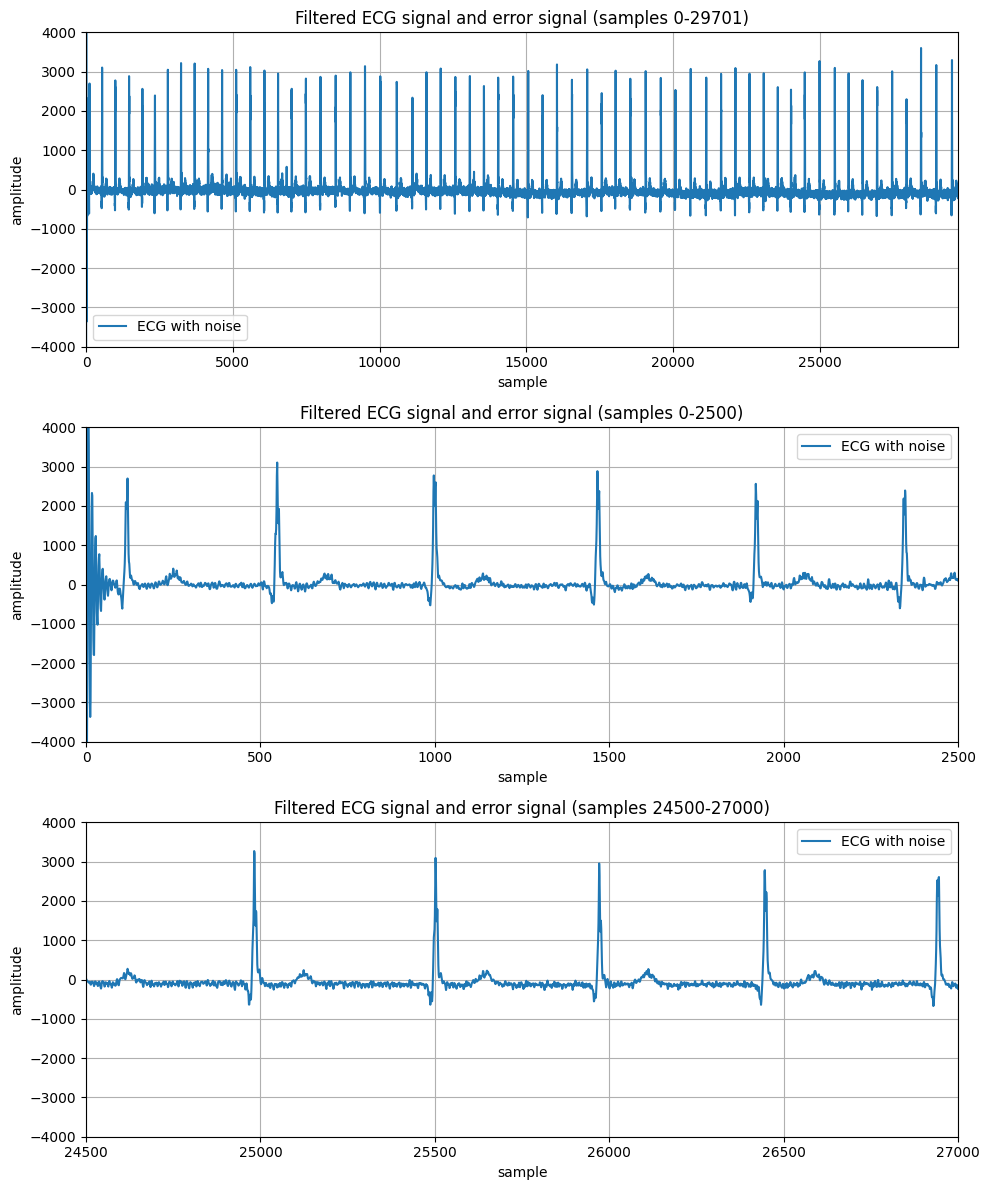

In [32]:
def plot_filtered_ecg_and_error_signal(ecg, error_signal):
    _, ax = plt.subplots(3, 1, figsize=(10, 12))

    for i, (xlim_min, xlim_max) in enumerate([(0, n_samples), (0, 2500), (24500, 27000)]):
        # ax[i].plot(ecg)
        # ax[i].plot(filtered_ecg)
        ax[i].plot(error_signal)
        ax[i].set_title(f'Filtered ECG signal and error signal (samples {xlim_min}-{xlim_max})')
        ax[i].set_xlabel('sample')
        ax[i].set_ylabel('amplitude')
        ax[i].set_xlim(xlim_min, xlim_max)
        # ax[i].set_ylim(min(error_signal), max(error_signal))
        ax[i].set_ylim(-4000, 4000)
        ax[i].legend(['ECG with noise', 'Filtered ECG', 'Error'])
        ax[i].grid()

    plt.tight_layout()
    plt.show()

plot_filtered_ecg_and_error_signal(ecg, nmls_result.err)

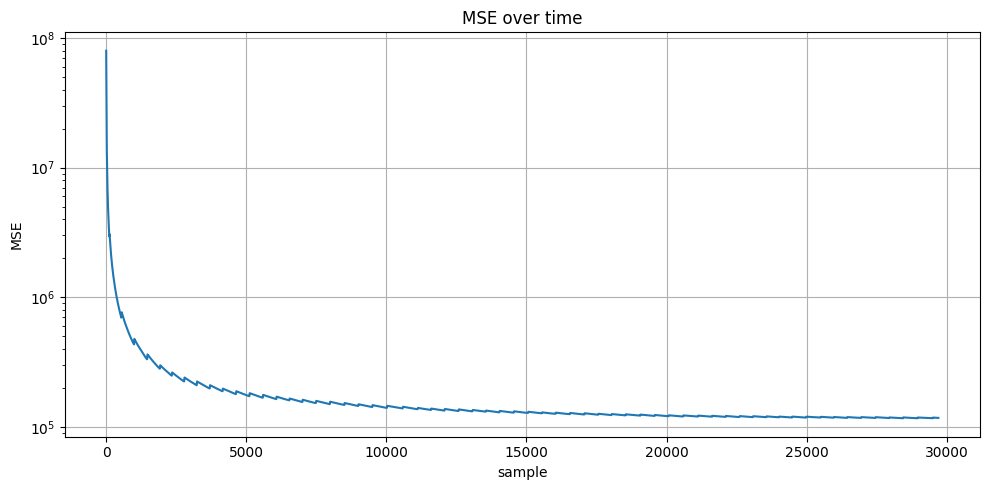

In [33]:
# plot mse over time
# TODO: is this correct?
# TODO: compare with the mse of the lms

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(nmls_result.mse)
ax.set_title('MSE over time')
ax.set_xlabel('sample')
ax.set_ylabel('MSE')
ax.semilogy()
ax.grid()
plt.tight_layout()
plt.show()


In [ ]:
# from tqdm.notebook import trange, tqdm
# for i in trange(10):
#     time.sleep(0.1)


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Interference from a 50 Hz powerline signal is quite common and can in principle also be removed with
a notch filter.

> 10  Design and implement a notch filter. Compare the results with the adaptive solutions.

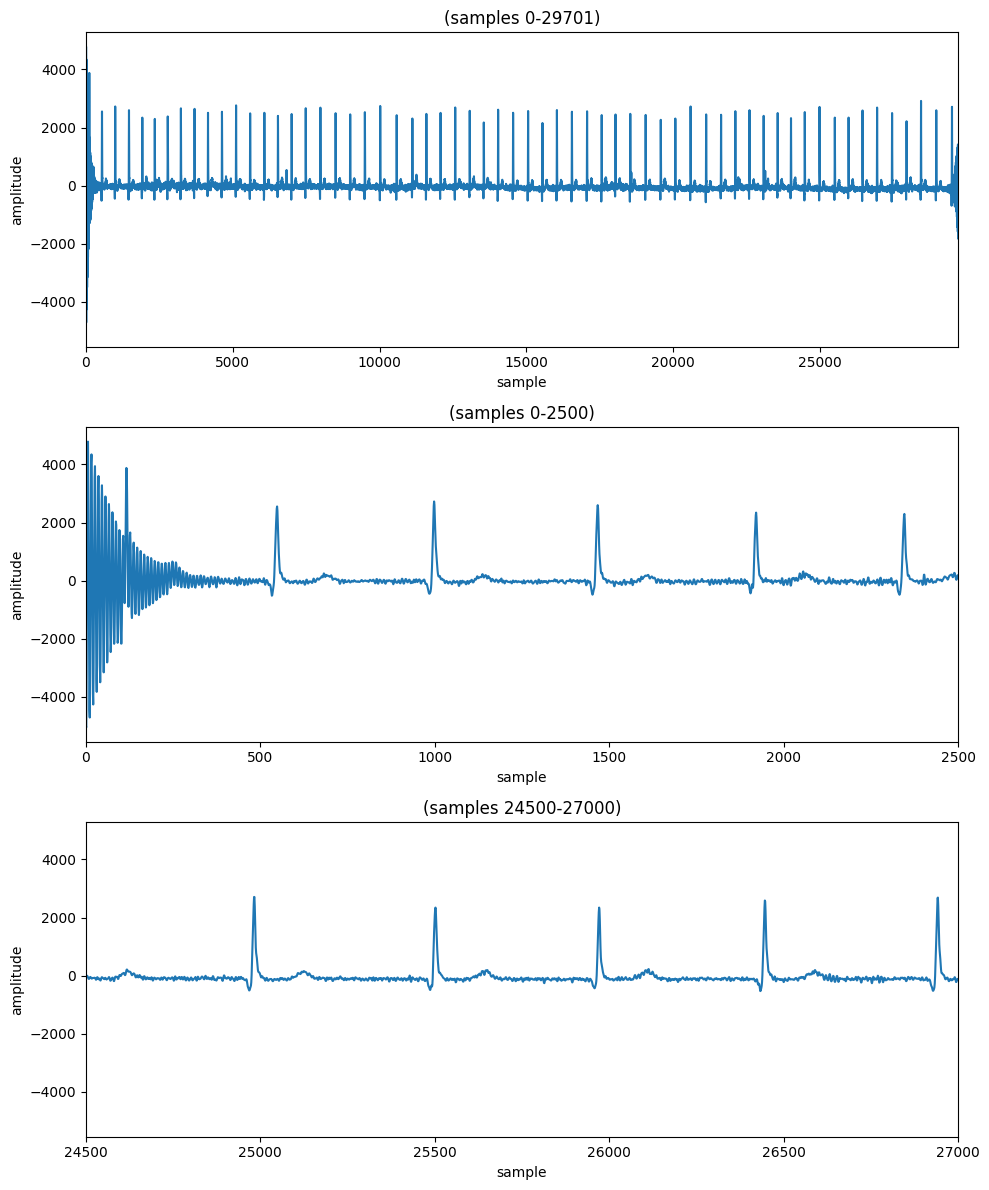

In [43]:
# Design and apply a 50 Hz notch filter.
Q = 30.0  # Quality factor
b, a = sp.signal.iirnotch(powerline_freq, Q, fs=Fs)
ecg_notch = sp.signal.filtfilt(b, a, ecg)

_, ax = plt.subplots(3, 1, figsize=(10, 12))

for i, (xlim_min, xlim_max) in enumerate([(0, n_samples), (0, 2500), (24500, 27000)]):
    ax[i].plot(ecg_notch)
    ax[i].set_title(f'(samples {xlim_min}-{xlim_max})')
    ax[i].set_xlabel('sample')
    ax[i].set_ylabel('amplitude')
    ax[i].set_xlim(xlim_min, xlim_max)

plt.tight_layout()
plt.show()


In [ ]:
# plot e_lms at 5 taps against ecg_notch

# TODO: compute misadjustment rate for lms filter